In [1]:
%matplotlib inline

import sys
import numpy as np
import tensorflow as tf
from tensorflow.python.ops import math_ops
from ESN import EchoStateRNNCell
import matplotlib.pyplot as plt

In [2]:
# Configs ----------------------------------------------------------------------

# takes only current needed GPU memory
config = tf.ConfigProto()
config.gpu_options.allow_growth = True

# random numbers
random_seed = None
rng = np.random.RandomState(random_seed)

Here we use tensorflow to implement a gradient descent optimization procedure for leaky echo-state networks. The procedure is taken from [jaeger, 2007](http://goo.gl/bqGAJu). with the difference that here we optimize only 
* **$\rho$** the spectral radius of the inner weights
* **$\tau$** the decay of the leaky
* **$s_w$** the scalin of the input weights
* **$\alpha$ a further parameter regulating the amount of rotation vs. expansion/contraction property of the dynamics defined by inner weight matrix of the network (see [ESN-definition.ipynb ](https://github.com/francesco-mannella/Echo-State-Networks/blob/master/ESN-definition.ipynb)).

In [3]:
# Utils ------------------------------------------------------------------------

def mackey_glass(stime = 30000, dt = 0.05,
        beta = 2., gamma = 1., n = 9.65, tau = 2):
    d = int(tau/dt)    
    x = 3.0*np.ones(2*stime + d)
    for t in range(tau-1, 2*stime):
        x[t+1] = x[t] + dt*(
                beta*x[t-d] / (1.0 + x[t-d]**n)
                - gamma*x[t] )
    return x[2*d: stime + 2*d], d


def MSE(P, Y):
    return tf.reduce_mean(tf.pow(P - Y, 2)) 

def NRMSE(P, Y):
    return tf.sqrt(MSE(P, Y)) / (tf.reduce_max(Y) - tf.reduce_min(Y))


def nrmse(P, Y):
    res = P - Y
    res = np.mean(res**2)
    res = np.sqrt(res)
    res = res/(Y.max() - Y.min())
    return res

In [4]:
# Global variables --------------------------------------------------------------

batches = 1
stime = 1000
num_units = 20
num_inputs = 1
# do the regression on a training subset of the timeseries
begin =  500
end = 750

# the activation function of the ESN
out_function = lambda x:  math_ops.tanh(x)


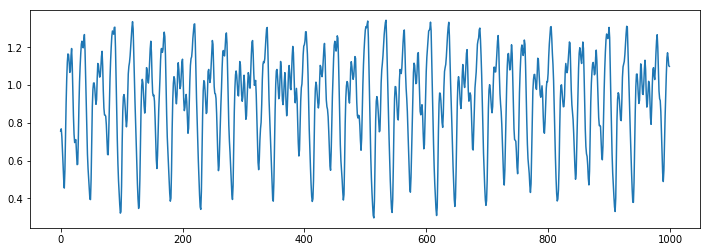

In [5]:
# input -------------------------------------------------------------------------
rnn_inputs = np.zeros((batches, stime, num_inputs), dtype="float32")
inp, tau = mackey_glass(stime = stime, dt = 0.25)
rnn_inputs = inp.copy().reshape(1,stime, 1)
rnn_init_state = np.zeros([batches, num_units], dtype="float32")
plt.figure(figsize=(12,4))
inp_line, = plt.plot(inp)

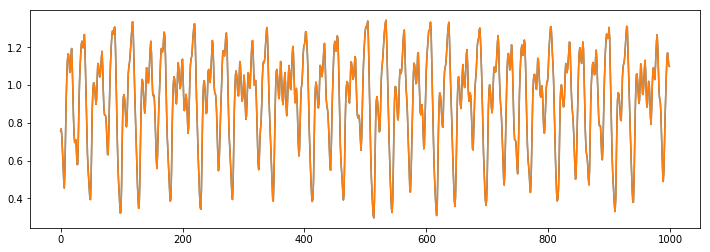

In [6]:
# the output target - mackey-glass ----------------------------------------------
rnn_target = inp.copy()
rnn_target = rnn_target.reshape(stime, 1).astype("float32")
plt.figure(figsize=(12,4))
inp_line, = plt.plot(rnn_inputs[0,:,:])
targ_line, = plt.plot(rnn_target)


In [7]:
# tensorflow graph -------------------------------------------------------------

tf.reset_default_graph()

graph = tf.Graph()
with graph.as_default() as g:
    
    rng = np.random.RandomState(random_seed)
    # gradient parameters
    lr = 0.1
    clipping_vars = True
    clipping_grads = False
    

    # Build the graph
    
    inputs = tf.placeholder(tf.float32, [batches, stime, num_inputs])
    target = tf.placeholder(tf.float32, [stime, 1])
    init_state = tf.placeholder(tf.float32, [1, num_units])

    # Init the ESN cell
    print "Making ESN init graph ..."
    cell = EchoStateRNNCell(num_units=num_units, 
                            num_inputs=num_inputs,
                            activation=out_function, 
                            decay=0.1, 
                            alpha=0.5,
                            rng=rng, 
                            batch = False,
                            optimize_vars=["rho", "alpha", "sw"])
    print "Done"
    
    # cell spreading of activations
    print "Making ESN spreading graph ..."
    states = []
    state = init_state
    for t in range(stime):
        state,_ = cell(inputs=inputs[0,t:(t+1),:], state=state)
        states.append(state)
    outputs = tf.reshape(states, [stime, num_units])   
    print "Done"   
    
    # ridge regression
    print "Making regression graph ..."
    # optimize also the lambda parameter of the ridge regression
    lmb = tf.get_variable("lmb", initializer=0.001,  dtype=tf.float32, trainable=False)  
    X = outputs[begin:end,:]
    Y = target[begin:end,:] 
    cell.Wout = tf.matmul(tf.matrix_inverse(tf.matmul(tf.transpose(X), X) +
                lmb*tf.eye(num_units)), tf.matmul(tf.transpose(X), Y))
    print "Done"
    
    cell.Wfb = tf.transpose(cell.Wout)
    
    print "Making test graph ..."
    cell.reset()
    readouts = []
    states = []
    state = init_state
    for t in range(stime):
        if t > 5:
            state,_ = cell(inputs=inputs[0,t:(t+1),:], state=state)
        else:
            state,_ = cell(inputs=tf.zeros([1, num_inputs]), state=state)
        states.append(state)
        readouts.append(cell.readouts)

    outputs = tf.reshape(states, [stime, num_units])   
    readouts = tf.reshape(readouts, [stime, cell.num_readouts])   
    print "Done"
    
    # train graph
    print "Making training graph ..."  
    # calculate the loss over all the timeseries (escluded the beginning)
    loss = MSE(readouts[begin:end,:], target[begin:end,:]) 
        
    # optimize
        
    # init gradient descent
    optimizer = tf.train.GradientDescentOptimizer(lr)
      
    if clipping_grads == True:
            
        # get gradients
        grads_and_vars = optimizer.compute_gradients(
            loss, [cell.rho, cell.alpha, cell.decay, cell.sw, lmb])
            
        #clip gradients
        clipped_grads_and_vars = [
            (tf.clip_by_value(grad,-.1, .1), var)
            for grad, var in grads_and_vars]
            
        # apply gradients
        train = optimizer.apply_gradients(clipped_grads_and_vars)
        
    elif clipping_grads == False:
            
        train = optimizer.minimize(loss)
        
    if clipping_vars == True:
        
        # clip parameters
        clipped_rho = tf.assign(cell.rho, tf.clip_by_value(cell.rho, 0.1, 1.0))
        clipped_alpha = tf.assign(cell.alpha, tf.clip_by_value(cell.alpha, 0.0, 1.0))
        clipped_decay = tf.assign(cell.decay, tf.clip_by_value(cell.decay, 0.01, 0.3))
        clipped_sw = tf.assign(cell.sw, tf.clip_by_value(cell.sw, 0.1, 10.0))
        clipped_lmb = tf.assign(lmb, tf.clip_by_value(lmb, 1.00e-10, 0.1))
        clip = tf.group(clipped_rho, clipped_alpha, clipped_decay, 
                        clipped_sw, clipped_lmb)
    
    print "Done"  
    

Making ESN init graph ...
Done
Making ESN spreading graph ...
Done
Making regression graph ...
Done
Making test graph ...
Done
Making training graph ...
Done


In [8]:
# run session -----------------------------------------------------------------
trials = 1000
with graph.as_default() as g:

    with tf.Session(config=config) as session:
        
        session.run(tf.global_variables_initializer())
        losses = np.zeros(trials)
        print "Executing the graph"
        for k in range(trials):
            
            rho, alpha, decay, sw, U, \
            curr_outputs, curr_readouts, \
            curr_loss, curr_lmb,_ = \
                session.run([cell.rho, cell.alpha, cell.decay, cell.sw,
                             cell.U, outputs, readouts, loss, lmb, train],
                            feed_dict={inputs:rnn_inputs,target: rnn_target,
                                       init_state:rnn_init_state})
                
            # clip parameters after update
            if clipping_vars == True:
                session.run(clip)
            
            if k%50 == 0 or k == trials-1:
                sys.stdout.write("step: {:4d}\t".format(k))
                sys.stdout.write("MSE: {:6.5f}\t".format(curr_loss))
                sys.stdout.write("NRMSE: {:6.5f}\t".format(curr_loss))
                sys.stdout.write("rho: {:5.3f}\t".format(rho))
                sys.stdout.write("alpha: {:5.3f}\t".format(alpha))
                sys.stdout.write("decay: {:5.3f}\t".format(decay))
                sys.stdout.write("sw: {:5.3f}\n".format(sw))

            losses[k] = curr_loss
        print "Done"


Executing the graph
step:    0	MSE: 0.00017	NRMSE: 0.00017	rho: 0.500	alpha: 0.500	decay: 0.100	sw: 4.000
step:   50	MSE: 0.00017	NRMSE: 0.00017	rho: 0.500	alpha: 0.500	decay: 0.100	sw: 4.000
step:  100	MSE: 0.00017	NRMSE: 0.00017	rho: 0.500	alpha: 0.500	decay: 0.100	sw: 4.000
step:  150	MSE: 0.00017	NRMSE: 0.00017	rho: 0.500	alpha: 0.500	decay: 0.100	sw: 4.000
step:  200	MSE: 0.00017	NRMSE: 0.00017	rho: 0.500	alpha: 0.501	decay: 0.100	sw: 4.000
step:  250	MSE: 0.00017	NRMSE: 0.00017	rho: 0.500	alpha: 0.501	decay: 0.100	sw: 4.000
step:  300	MSE: 0.00017	NRMSE: 0.00017	rho: 0.500	alpha: 0.501	decay: 0.100	sw: 4.000
step:  350	MSE: 0.00017	NRMSE: 0.00017	rho: 0.500	alpha: 0.501	decay: 0.100	sw: 3.999
step:  400	MSE: 0.00017	NRMSE: 0.00017	rho: 0.499	alpha: 0.501	decay: 0.100	sw: 3.999
step:  450	MSE: 0.00017	NRMSE: 0.00017	rho: 0.499	alpha: 0.502	decay: 0.100	sw: 3.999
step:  500	MSE: 0.00017	NRMSE: 0.00017	rho: 0.499	alpha: 0.502	decay: 0.100	sw: 3.999
step:  550	MSE: 0.00017	NRMSE: 0.0

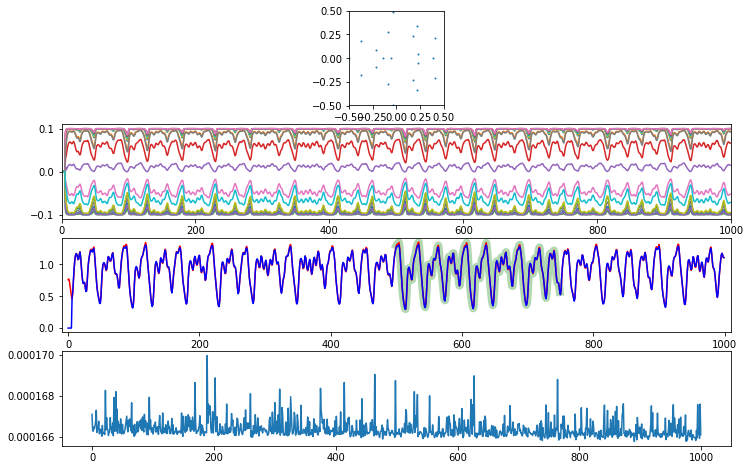

In [9]:
    # plot results ---------------------------------------------------------------
    
    plt.figure(figsize=(12,8))
    plt.subplot(411, aspect="equal")
    eigs = np.linalg.eigvals(U*rho)
    plt.scatter(eigs.real, eigs.imag, s=1)
    plt.xlim([-rho, rho])
    plt.ylim([-rho, rho])
    plt.subplot(412)
    plt.plot(curr_outputs)
    #plt.imshow(curr_outputs.T, aspect="auto")
    plt.xlim([0, stime])
    plt.subplot(413)
    plt.plot(range(begin,end),rnn_target[begin:end,:], 
            color="green", lw=8, alpha=.3)
    plt.plot(rnn_target, color="red")
    plt.plot(curr_readouts, color="blue")
    plt.xlim([-10, stime+10])
    plt.subplot(414)
    plt.plot(losses)
    plt.show()
